In [4]:
#! pip install pandas

In [5]:
import os
import shutil

import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
from skimage.transform import resize
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf

## Read dataset

In [6]:
# Main Directory
main_dir = 'Merged_folder/'
print(f'The total number of images is {len(os.listdir(main_dir))}')

The total number of images is 825


In [7]:
# specify the img directory path
path = main_dir

# list files in img directory
files = os.listdir(path)

image_list = []

for file in files:
    # make sure file is an image
    if file.endswith(('.jpg', '.png', 'jpeg', 'tiff')):
        #img_path = path + file
        image_list.append(os.path.join(path, file))
        
print(f'Image list top 5 examples:')
image_list[:5]

Image list top 5 examples:


['Merged_folder/73001_image_2016-10-30.tiff',
 'Merged_folder/73001_image_2016-03-20.tiff',
 'Merged_folder/73001_image_2016-08-07.tiff',
 'Merged_folder/54001_image_2016-01-24.tiff',
 'Merged_folder/73001_image_2016-06-19.tiff']

# Train-Test Split

In [8]:
# Train-Test split
image_list = np.array(image_list)
x_train, x_test = train_test_split(image_list,test_size=0.2)
#x_train, x_val = train_test_split(x_train,test_size=0.1)

In [9]:
# To numpy
x_train = np.array(x_train)
#x_val = np.array(x_val)
x_test = np.array(x_test)

# Create a custom dataloader

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for train
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)


In [11]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, image_paths,
                 batch_size,
                 input_size = (224, 224, 8),
                 shuffle = True, 
                 augmentation = None):
        
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        # Length of dataset
        self.n = len(self.image_paths)
        
    # Helper function to read the image
    def __get_image(self, path, target_size):
        # Read the image and convert to numpy array
        image = io.imread(path)
        #print(f'max {image.max()}, min: {image.min()}, type: {type(image)}')
        # Resize the image and normalize values
        image_arr = resize(image,(target_size[0], target_size[1]))
        #image_arr = tf.image.resize(image,(target_size[0], target_size[1]),method=tf.image.ResizeMethod.BILINEAR).numpy()
        #print(f'The shape of the image before reshape: {image_arr.shape}, of type{type(image_arr)}')
        #image_arr = image_arr/255.
        return image_arr
    
    def __getitem__(self, index):     
        batches = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]

        X_batch = []
        # for each image in batch
        for image_name in batches:
            # Get the image
            image = self.__get_image(image_name, self.input_size) 
            X_batch.append(image)
        
        X_batch = np.array(X_batch)
        
        # Augmentation
        if self.augmentation:
            # prepare iterator
            X_batch = self.augmentation.flow(X_batch, batch_size=self.batch_size, shuffle=True).next()
            #print('Augmentation done!')

        #print(f'The shape of the batch is : {X_batch.shape} of type: {type(X_batch)}')
        return X_batch, X_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_paths)
            
    def __len__(self):
        return self.n // self.batch_size

In [12]:
batch_size = 8
target_size = (740, 740, 12)
traingen = CustomDataGen(x_train,
                         batch_size=batch_size, 
                         input_size=target_size, 
                         augmentation=train_datagen, 
                         shuffle = True)
                         #augmentation=None)

(1, 2, 3, 740, 740, 12)
(1, 2, 3, 740, 740, 12)
(1, 2, 3, 740, 740, 12)
(1, 2, 3, 740, 740, 12)
(1, 2, 3, 740, 740, 12)
(1, 2, 3, 740, 740, 12)
(1, 2, 3, 740, 740, 12)
(1, 2, 3, 740, 740, 12)
(1, 2, 3, 740, 740, 12)


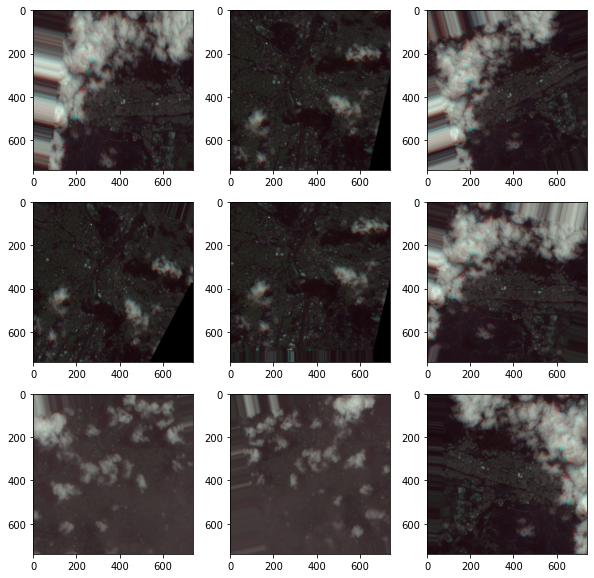

In [19]:
ax = plt. subplots(3, 3, figsize=(10,10))
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generator
    example_gen = CustomDataGen(x_train,
                         batch_size=3, 
                         input_size=target_size, 
                         augmentation=train_datagen)
    # generate batch of images
    example_batch = np.array(next(zip(example_gen)))
    print(example_batch.shape)
    # Take RGB bands from first image in batch
    example_image = example_batch[0, 0, 0, :, :, 0:3]

    # plot raw pixel data
    plt.imshow(example_image)
    
# show the figure
plt.show()

# VAE

In [11]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, MaxPooling2D, UpSampling2D
#from keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [12]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

## Encoder Part

In [13]:
input_data = Input(shape=target_size, name='encoder_input')

encoder = Conv2D(32, (5,5), activation='relu')(input_data)
encoder = MaxPooling2D((2,2))(encoder)

encoder = Conv2D(64, (3,3), activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)

encoder = Conv2D(64, (3,3), activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)

conv_shape = K.int_shape(encoder) #Shape of conv to be provided to decoder

encoder = Flatten()(encoder)
encoder = Dense(200, activation='relu')(encoder)

## Latent Distribution and Sampling

In [14]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = K.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

In [15]:
latent_dim = 200 # Number of latent dim parameters

distribution_mean = Dense(latent_dim, name='mean')(encoder)
distribution_variance = Dense(latent_dim, name='log_variance')(encoder)
latent_encoding = Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [16]:
encoder_model = Model(input_data, latent_encoding)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 740, 740, 1  0           []                               
                                2)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 736, 736, 32  9632        ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 368, 368, 32  0           ['conv2d[0][0]']                 
                                )                                                             

## Decoder Part

In [17]:
decoder_input = Input(shape=(latent_dim), name='decoder_input')
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3])(decoder_input)

decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)

"""
encoder = Conv2D(64, (5,5), activation='relu')(input_data)
encoder = MaxPooling2D((2,2))(encoder)

encoder = Conv2D(64, (3,3), activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)

encoder = Conv2D(32, (3,3), activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)
"""

decoder = UpSampling2D((2,2))(decoder)
decoder = Conv2DTranspose(64, (3,3), activation='relu')(decoder)

decoder = UpSampling2D((2,2))(decoder)
decoder = Conv2DTranspose(64, (3,3), activation='relu')(decoder)

decoder = Conv2DTranspose(32, (3,3), activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)

decoder_output = Conv2DTranspose(target_size[2], (5,5), activation='relu')(decoder)

In [18]:
decoder_model = Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 518400)            104198400 
                                                                 
 reshape (Reshape)           (None, 90, 90, 64)        0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 180, 180, 64)     0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 182, 182, 64)     36928     
 nspose)                                                         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 364, 364, 64)     0   

## Combining

In [19]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)

In [20]:
autoencoder = Model(input_data, decoded)

# Train model

## Loss Function (Reconstruction Loss + KL-loss)
https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb

In [21]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch#*target_size[0]*target_size[1]
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tf.square(distribution_mean) - tf.exp(distribution_variance)
        kl_loss_batch = tf.reduce_mean(kl_loss)
        #return kl_loss_batch*(-5e-4)
        return kl_loss_batch*(-5e-4)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        #return reconstruction_loss_batch + kl_loss_batch
        return K.mean(reconstruction_loss_batch + kl_loss_batch)
    
    return total_loss

## Compile the model

In [22]:
# Compile VAE
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 740, 740, 12)]    0         
                                                                 
 model (Functional)          (None, 200)               103825656 
                                                                 
 model_1 (Functional)        (None, 740, 740, 12)      104300332 
                                                                 
Total params: 208,125,988
Trainable params: 208,125,988
Non-trainable params: 0
_________________________________________________________________


In [23]:
autoencoder.fit(traingen, epochs=20)

Epoch 1/20


/Users/davidrestrepo/miniforge3/envs/dengue/lib/python3.9/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (8, 740, 740, 12) (12 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


Metal device set to: Apple M1


2022-05-22 21:11:44.314196: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-22 21:11:44.314342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-22 21:11:44.340389: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-22 21:11:44.341355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 21:11:44.388637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 21:11:45.646344: I tensorflow/core/grappler/o

82/82 [==============================] - 870s 11s/step - batch: 40.5000 - size: 8.0000 - loss: 177.1306
Epoch 2/20
82/82 [==============================] - 909s 11s/step - batch: 40.5000 - size: 8.0000 - loss: 0.1034
Epoch 3/20
82/82 [==============================] - 856s 10s/step - batch: 40.5000 - size: 8.0000 - loss: 0.1017
Epoch 4/20
82/82 [==============================] - 804s 10s/step - batch: 40.5000 - size: 8.0000 - loss: 0.1011
Epoch 5/20
82/82 [==============================] - 798s 10s/step - batch: 40.5000 - size: 8.0000 - loss: 0.0969
Epoch 6/20
82/82 [==============================] - 807s 10s/step - batch: 40.5000 - size: 8.0000 - loss: 0.0957
Epoch 7/20
82/82 [==============================] - 845s 10s/step - batch: 40.5000 - size: 8.0000 - loss: 0.0950
Epoch 8/20
82/82 [==============================] - 699s 9s/step - batch: 40.5000 - size: 8.0000 - loss: 0.0951
Epoch 9/20
82/82 [==============================] - 655s 8s/step - batch: 40.5000 - size: 8.0000 - loss: 0

# Save the model

In [24]:
# Save the model
autoencoder.save('Models/vae_v2.h5')

2022-05-23 01:05:33.976086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:05:34.051985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:05:34.056133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:05:34.077407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:05:34.977938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-23 01:05:35.852705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# Test Model

In [25]:
testgen = CustomDataGen(x_test,
                         batch_size=batch_size, 
                         input_size=target_size, 
                         augmentation=None)

# Results

(1, 2, 8, 740, 740, 12)


/Users/davidrestrepo/miniforge3/envs/dengue/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2022-05-23 01:05:43.121666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 2, 8, 740, 740, 12)
(1, 2, 8, 740, 740, 12)


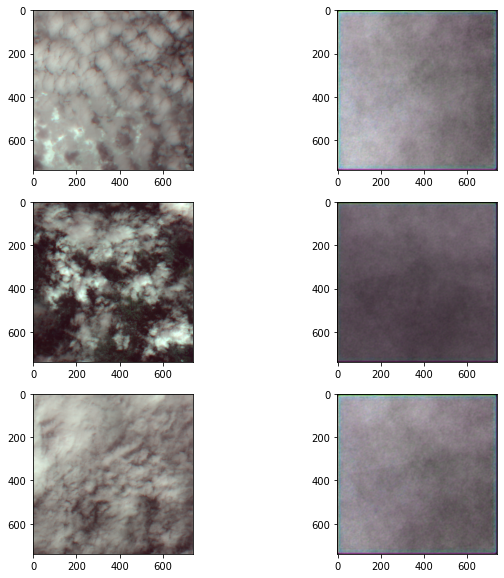

In [26]:
fig, ax = plt. subplots(3, 2, figsize=(10,10))

for i in range(3):
    # generator
    # generate batch of images
    example_batch = np.array(next(zip(testgen)))
    print(example_batch.shape)
    # Take RGB bands from first image in batch
    example_image = example_batch[0, 0, i, :, :, 0:3]
    # plot raw pixel data
    ax[i, 0].imshow(example_image)
    
    # Predicted Images
    example_image_test = example_batch[0, 0, i, :, :, :]
    example_image_test = np.expand_dims(example_image_test, axis=0)
    output = autoencoder.predict(example_image_test)
    op_image = output[0, :, :, 0:3]
    ax[i, 1].imshow(op_image)

plt.show()